# Анализ и предсказание цен на автомобили на основе данных с [Auto.ru](https://auto.ru/cars)

## Часть 1. Начало рвботы с данными

Был произведен парсинг сайта [Auto.ru](https://auto.ru/cars). Собиралась информация по 99 страницам объявлений для новых и старых авто в Санкт-Петербурге, Москве и Владивостоке. 

Санкт-Петербург и Москва были выбраны как наиболее широкие рынки в РФ. Владивосток был добавлен для того, чтобы сбалансировать распределение автомобилей с левым и правым рулем. 

### Структура датасета:
```
{
    "city",                  # регион
    "is_new",                # новый / с пробегом
    "price",                 # цена в руб., целевая переменная
    "tax_per_year",          # налог в руб. в год
    "year",                  # год выпуска
    "km-age",                # пробег в км
    "brand",                 # марка
    "model",                 # модель
    "color",                 # цвет

    "body_type",             # тип кузова
    "drive_type",            # привод
    "transmission",          # коробка
    "engine_type",           # тип двигателя
    "engine_volume",         # объем двигателя (NULL для электроавтомобилей)
    "power_hp",              # мощность двигателя
    "is_left_hand_drive",    # тип руля

    "url"                    # идентификатор
}
```

### Загрузка датасета

In [210]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap

In [211]:
df = pd.read_csv("./parser/data/raw.csv")

In [212]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9717 entries, 0 to 9716
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                9717 non-null   object 
 1   is_new              9717 non-null   bool   
 2   price               9698 non-null   float64
 3   tax_per_year        9444 non-null   float64
 4   year                9717 non-null   int64  
 5   km-age              9717 non-null   int64  
 6   brand               9717 non-null   object 
 7   model               9717 non-null   object 
 8   color               9717 non-null   object 
 9   body_type           9717 non-null   object 
 10  drive_type          9717 non-null   object 
 11  transmission        9717 non-null   object 
 12  engine_type         9715 non-null   object 
 13  engine_volume       9413 non-null   float64
 14  power_hp            9717 non-null   int64  
 15  is_left_hand_drive  9698 non-null   object 
 16  url   

,city,is_new,price,tax_per_year,year,km-age,brand,model,color,body_type,drive_type,transmission,engine_type,engine_volume,power_hp,is_left_hand_drive,url
0,moskva,True,3650000.0,0.0,2023,0,GAC Aion,Hyptec GT (Hyper GT),серый,седан,задний,automatic,electric,NaN,340,True,https://auto.ru/cars/new/group/aion/hyper_gt/2...
1,moskva,True,5800000.0,73500.0,2025,0,BYD,FangChengBao Titanium 7,синий,suv,полный,variator,hybrid,1.5,490,True,https://auto.ru/cars/new/group/byd/fangchengba...
2,moskva,True,10990000.0,48900.0,2024,0,Dongfeng,Mengshi M-Hero 917,чёрный,suv,полный,automatic,hybrid,1.5,816,True,https://auto.ru/cars/new/group/dongfeng/mengsh...
3,moskva,True,3239990.0,8000.0,2024,0,FAW,Bestune T90,белый,suv,передний,robot,petrol,1.5,160,True,https://auto.ru/cars/new/group/faw/bestune_t90...
4,moskva,True,8990000.0,40200.0,2025,0,Infiniti,QX60,чёрный,suv,полный,automatic,petrol,2.0,268,True,https://auto.ru/cars/new/group/infiniti/qx60/2...


### Очистка

In [213]:
df = df[df["price"].notna()].copy()
df["log_price"] = np.log(df["price"])

df["year"] = df["year"].astype(int)
df["is_new"] = df["is_new"].astype(bool)
df["is_left_hand_drive"] = df["is_left_hand_drive"].astype(bool)

In [214]:
df["is_electric"] = df["engine_type"].eq("electric")
df.loc[df["is_electric"], "engine_volume"] = np.nan

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9698 entries, 0 to 9716
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                9698 non-null   object 
 1   is_new              9698 non-null   bool   
 2   price               9698 non-null   float64
 3   tax_per_year        9425 non-null   float64
 4   year                9698 non-null   int64  
 5   km-age              9698 non-null   int64  
 6   brand               9698 non-null   object 
 7   model               9698 non-null   object 
 8   color               9698 non-null   object 
 9   body_type           9698 non-null   object 
 10  drive_type          9698 non-null   object 
 11  transmission        9698 non-null   object 
 12  engine_type         9696 non-null   object 
 13  engine_volume       9394 non-null   float64
 14  power_hp            9698 non-null   int64  
 15  is_left_hand_drive  9698 non-null   bool   
 16  url        

In [216]:
df_new = df[df["is_new"] == True].copy()
df_used = df[df["is_new"] == False].copy()

print(len(df_new), len(df_used))

995 8703


## Часть 2. EDA

### Распределение цены

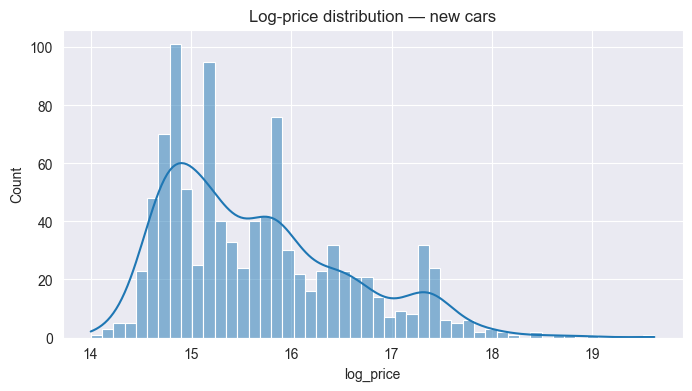

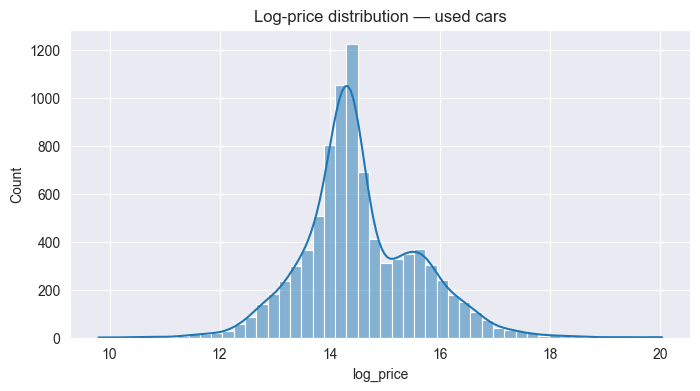

In [219]:
plt.figure(figsize=(8, 4))
sns.histplot(df_new["log_price"], bins=50, kde=True)
plt.title("Log-price distribution — new cars")
plt.xlabel("log_price")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_used["log_price"], bins=50, kde=True)
plt.title("Log-price distribution — used cars")
plt.xlabel("log_price")
plt.show()

### Распределение пробега подержанных автомобилей

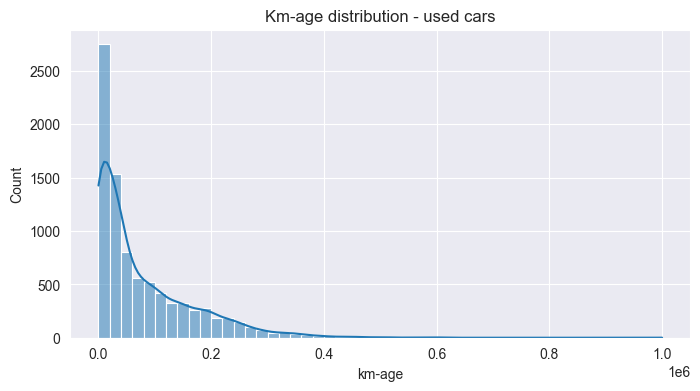

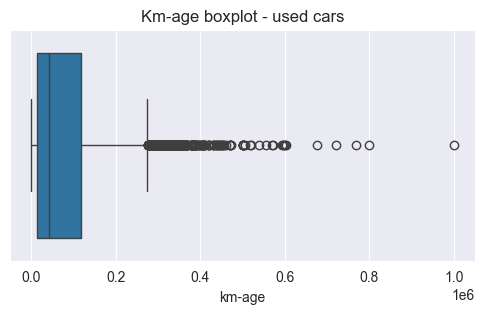

In [220]:
plt.figure(figsize=(8, 4))
sns.histplot(df_used["km-age"], bins=50, kde=True)
plt.title("Km-age distribution - used cars")
plt.xlabel("km-age")
plt.show()

plt.figure(figsize=(6, 3))
sns.boxplot(x=df_used["km-age"])
plt.title("Km-age boxplot - used cars")
plt.show()

> Рассматривать аналогичные графики для новых авто смысла не имеет, так как они имеют нулевой пробег.

### Распределение года выпуска

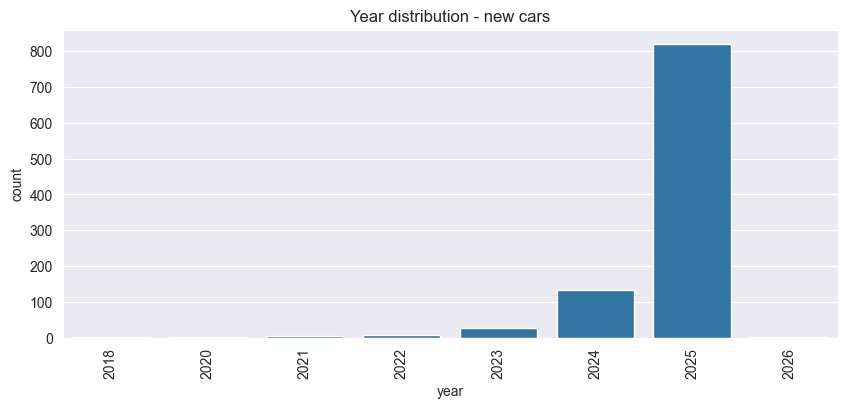

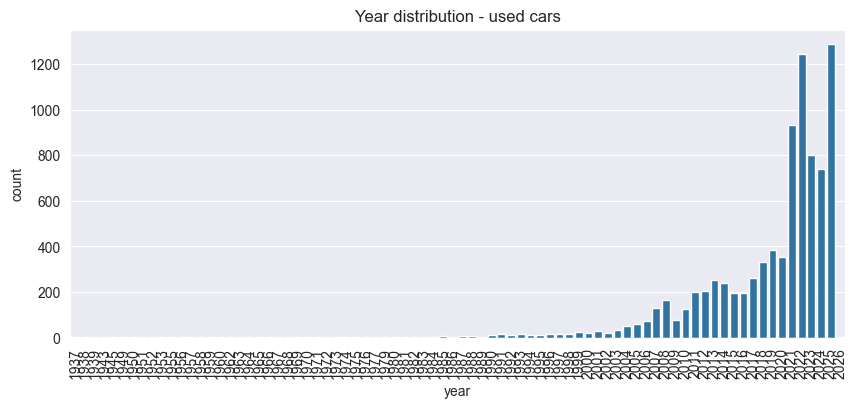

In [221]:
plt.figure(figsize=(10, 4))
sns.countplot(x="year", data=df_new)
plt.xticks(rotation=90)
plt.title("Year distribution - new cars")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x="year", data=df_used)
plt.xticks(rotation=90)
plt.title("Year distribution - used cars")
plt.show()

### Распределение типа двигателя

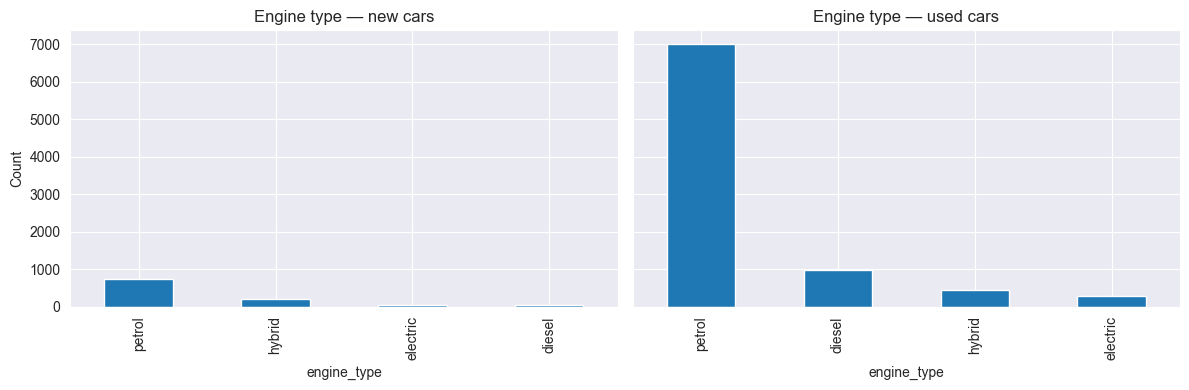

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

df_new.loc[df_new["engine_type"] != "unknown", "engine_type"].value_counts().plot(
    kind="bar", ax=axes[0], title="Engine type — new cars"
)
df_used.loc[df_used["engine_type"] != "unknown", "engine_type"].value_counts().plot(
    kind="bar", ax=axes[1], title="Engine type — used cars"
)

for ax in axes:
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

### Распределение мощности двигателя

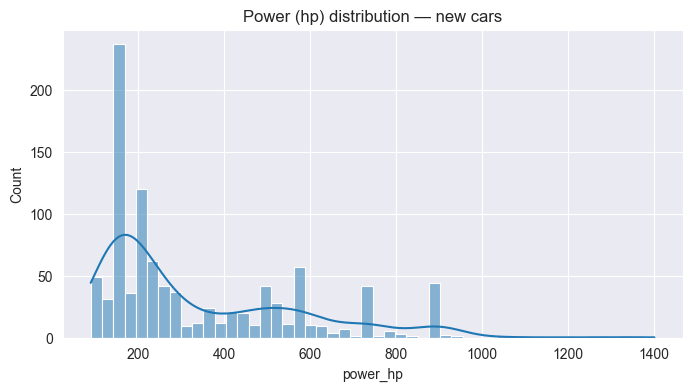

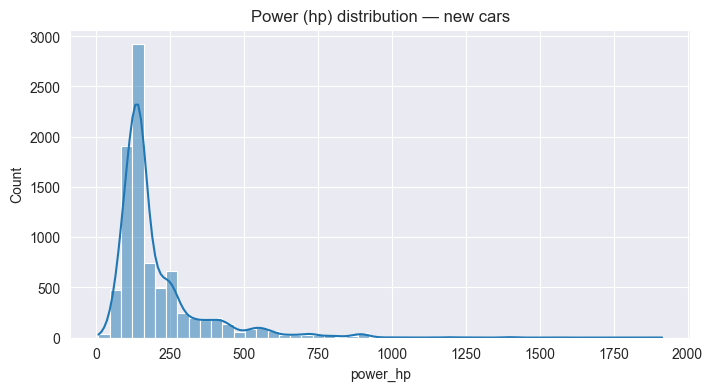

In [225]:
plt.figure(figsize=(8, 4))
sns.histplot(df_new["power_hp"], bins=50, kde=True)
plt.title("Power (hp) distribution — new cars")
plt.xlabel("power_hp")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_used["power_hp"], bins=50, kde=True)
plt.title("Power (hp) distribution — new cars")
plt.xlabel("power_hp")
plt.show()

### Распределение объема двигателя

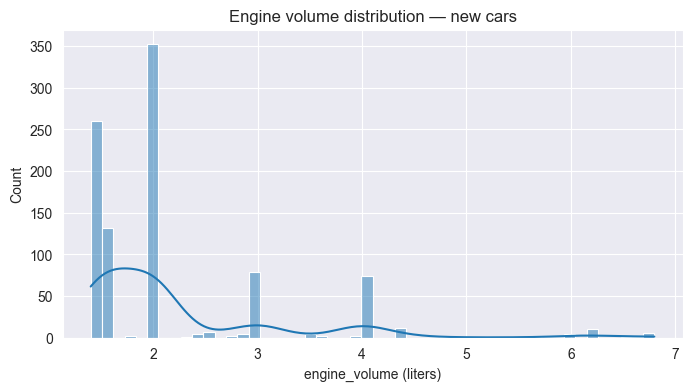

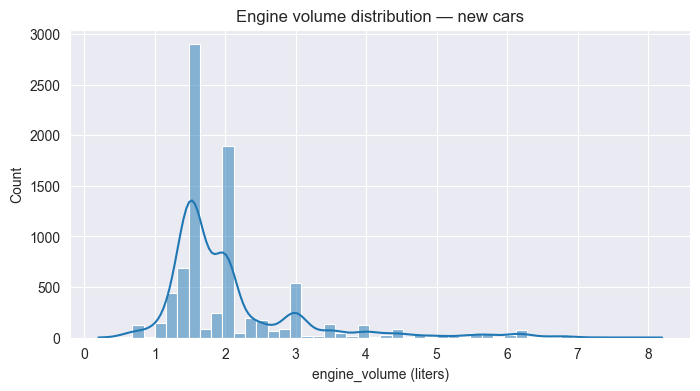

In [227]:
plt.figure(figsize=(8, 4))
sns.histplot(df_new.loc[~df_new["is_electric"], "engine_volume"], bins=50, kde=True)
plt.title("Engine volume distribution — new cars")
plt.xlabel("engine_volume (liters)")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_used.loc[~df_used["is_electric"], "engine_volume"], bins=50, kde=True)
plt.title("Engine volume distribution — new cars")
plt.xlabel("engine_volume (liters)")
plt.show()

### Распределение типа кузова

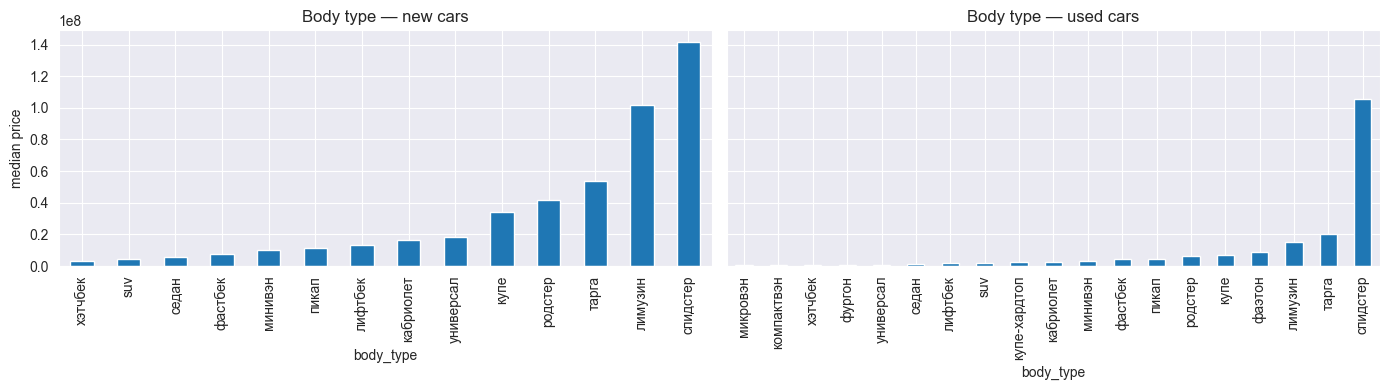

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

df_new.groupby("body_type")["price"].median().sort_values().plot(
    kind="bar", ax=axes[0], title="Body type — new cars"
)

df_used.groupby("body_type")["price"].median().sort_values().plot(
    kind="bar", ax=axes[1], title="Body type — used cars"
)

for ax in axes:
    ax.set_ylabel("median price")

plt.tight_layout()
plt.show()

### Распределение типа привода

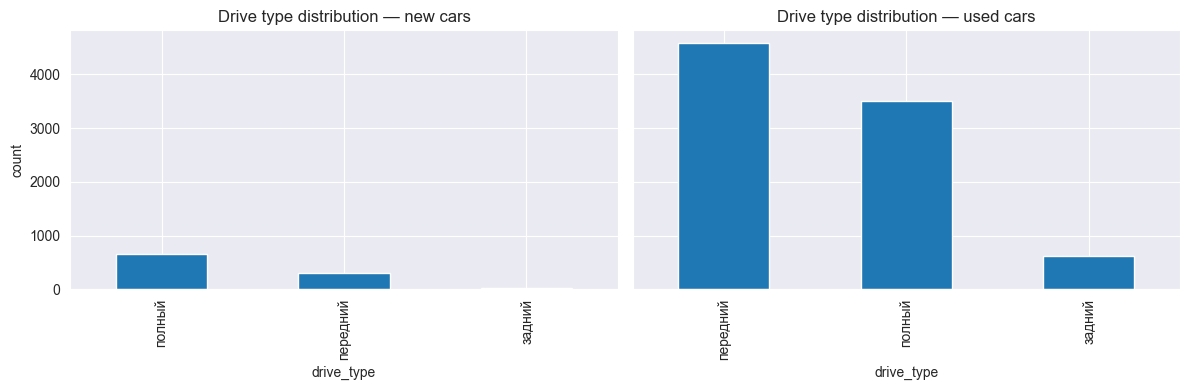

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

df_new["drive_type"].value_counts().plot(
    kind="bar",
    ax=axes[0]
)
axes[0].set_title("Drive type distribution — new cars")
axes[0].set_xlabel("drive_type")
axes[0].set_ylabel("count")

df_used["drive_type"].value_counts().plot(
    kind="bar",
    ax=axes[1]
)
axes[1].set_title("Drive type distribution — used cars")
axes[1].set_xlabel("drive_type")

plt.tight_layout()
plt.show()

### Распределение типа коробки передач

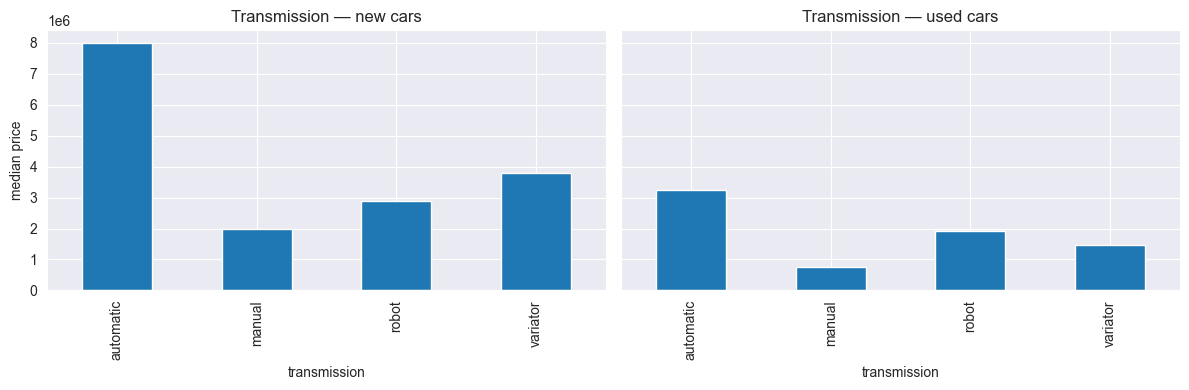

In [230]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

df_new.groupby("transmission")["price"].median().plot(
    kind="bar", ax=axes[0], title="Transmission — new cars"
)

df_used.groupby("transmission")["price"].median().plot(
    kind="bar", ax=axes[1], title="Transmission — used cars"
)

for ax in axes:
    ax.set_ylabel("median price")

plt.tight_layout()
plt.show()

### Топ-10 брендов по количеству объявлений

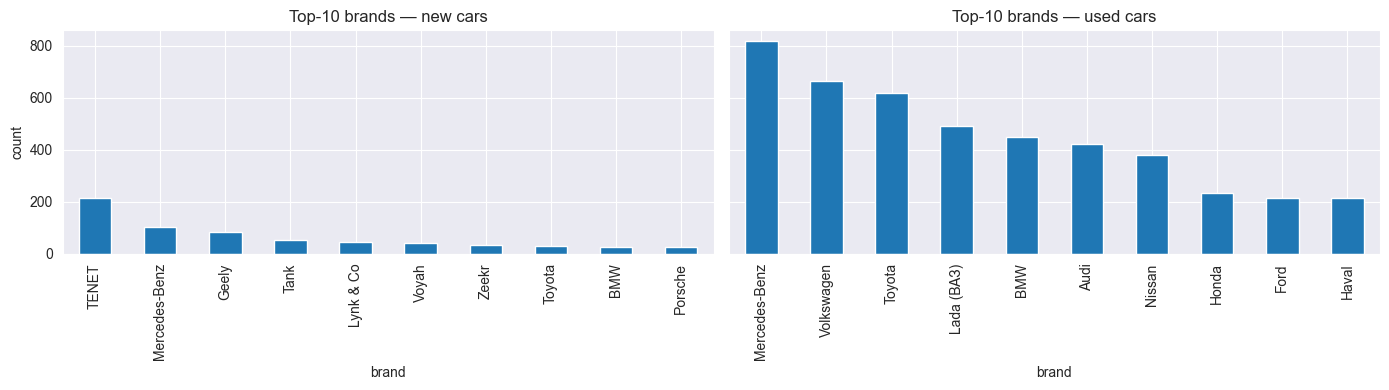

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

df_new["brand"].value_counts().head(10).plot(
    kind="bar",
    ax=axes[0]
)
axes[0].set_title("Top-10 brands — new cars")
axes[0].set_xlabel("brand")
axes[0].set_ylabel("count")

df_used["brand"].value_counts().head(10).plot(
    kind="bar",
    ax=axes[1]
)
axes[1].set_title("Top-10 brands — used cars")
axes[1].set_xlabel("brand")

plt.tight_layout()
plt.show()

### Топ-10 брендов по средней цене автомобилей

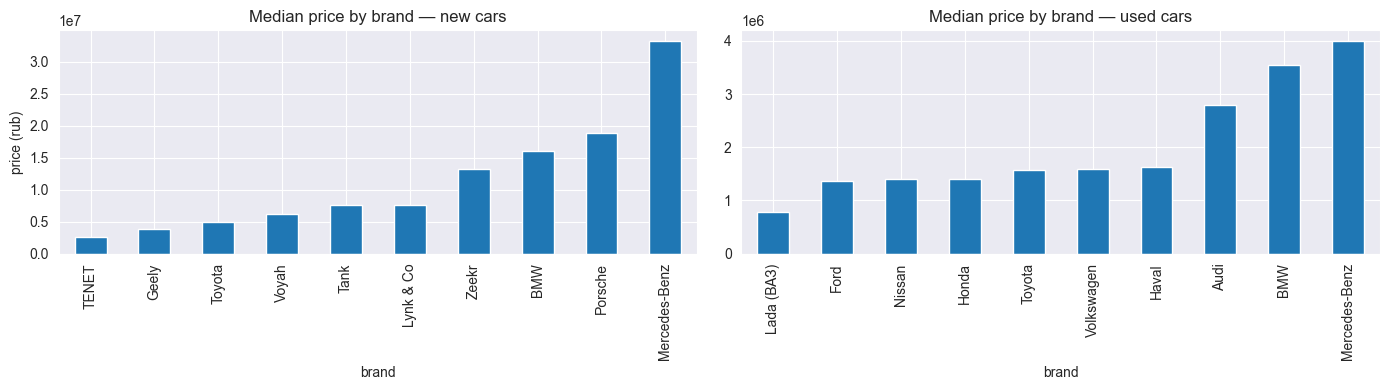

In [232]:
top_brands_new = df_new["brand"].value_counts().head(10).index
top_brands_used = df_used["brand"].value_counts().head(10).index

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

(
    df_new[df_new["brand"].isin(top_brands_new)]
    .groupby("brand")["price"]
    .median()
    .sort_values()
    .plot(kind="bar", ax=axes[0])
)
axes[0].set_title("Median price by brand — new cars")
axes[0].set_xlabel("brand")
axes[0].set_ylabel("price (rub)")

(
    df_used[df_used["brand"].isin(top_brands_used)]
    .groupby("brand")["price"]
    .median()
    .sort_values()
    .plot(kind="bar", ax=axes[1])
)
axes[1].set_title("Median price by brand — used cars")
axes[1].set_xlabel("brand")

plt.tight_layout()
plt.show()

### Зависимость цены и пробега

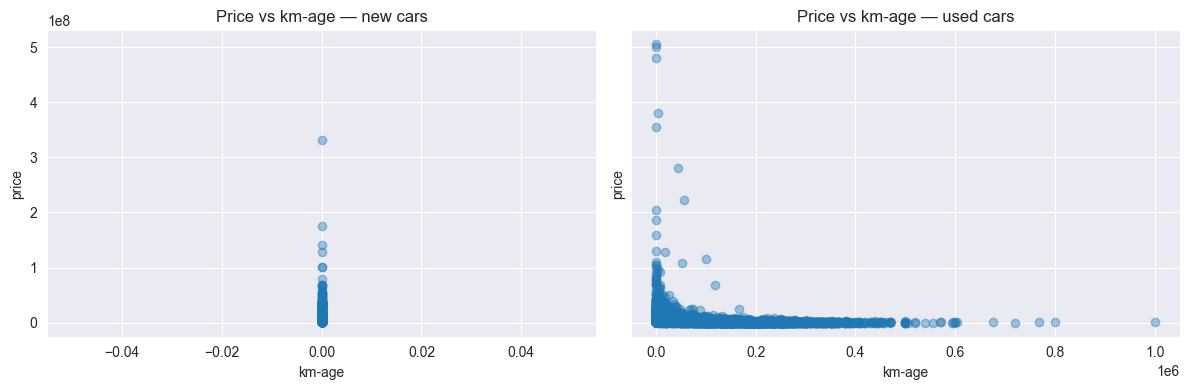

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].scatter(df_new["km-age"], df_new["price"], alpha=0.4)
axes[0].set_title("Price vs km-age — new cars")

axes[1].scatter(df_used["km-age"], df_used["price"], alpha=0.4)
axes[1].set_title("Price vs km-age — used cars")

for ax in axes:
    ax.set_xlabel("km-age")
    ax.set_ylabel("price")

plt.tight_layout()
plt.show()

### Зависимость цены и года выпуска

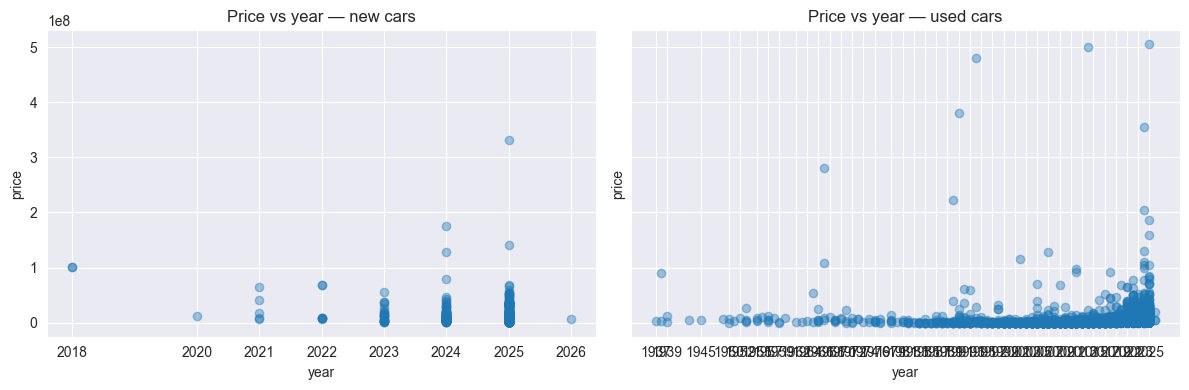

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].scatter(df_new["year"], df_new["price"], alpha=0.4)
axes[0].set_title("Price vs year — new cars")

years_new = sorted(df_new["year"].unique())
axes[0].set_xticks(years_new)

axes[1].scatter(df_used["year"], df_used["price"], alpha=0.4)
axes[1].set_title("Price vs year — used cars")

years_used = sorted(df_used["year"].unique())
axes[1].set_xticks(
    years_used[::2]
)

for ax in axes:
    ax.set_xlabel("year")
    ax.set_ylabel("price")

plt.tight_layout()
plt.show()

### Зависимость цены и мощности двигателя

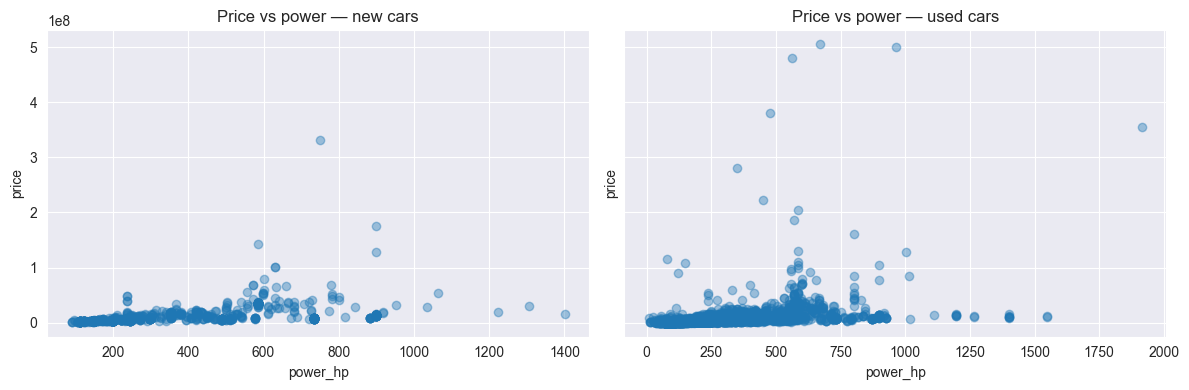

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].scatter(df_new["power_hp"], df_new["price"], alpha=0.4)
axes[0].set_title("Price vs power — new cars")

axes[1].scatter(df_used["power_hp"], df_used["price"], alpha=0.4)
axes[1].set_title("Price vs power — used cars")

for ax in axes:
    ax.set_xlabel("power_hp")
    ax.set_ylabel("price")

plt.tight_layout()
plt.show()

### Распределение количества объявлений по городам

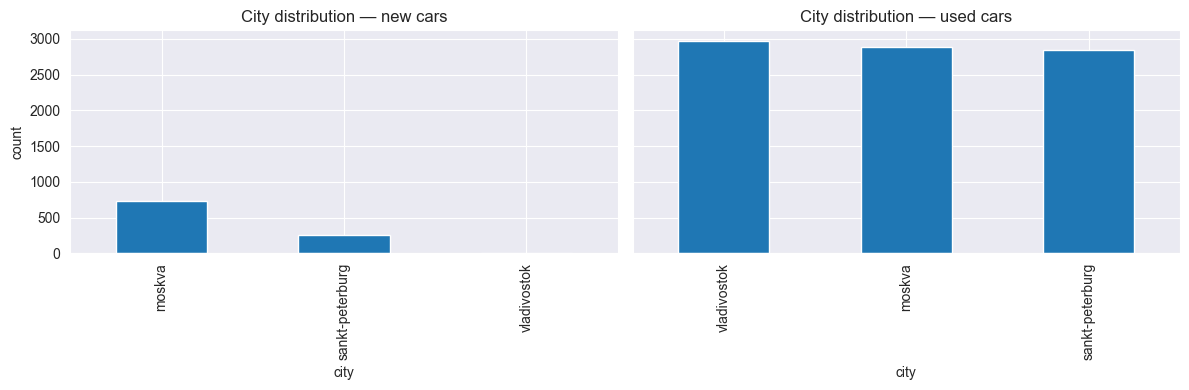

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

df_new["city"].value_counts().plot(
    kind="bar",
    ax=axes[0]
)
axes[0].set_title("City distribution — new cars")
axes[0].set_xlabel("city")
axes[0].set_ylabel("count")

df_used["city"].value_counts().plot(
    kind="bar",
    ax=axes[1]
)
axes[1].set_title("City distribution — used cars")
axes[1].set_xlabel("city")

plt.tight_layout()
plt.show()

### Распределение цены по городам

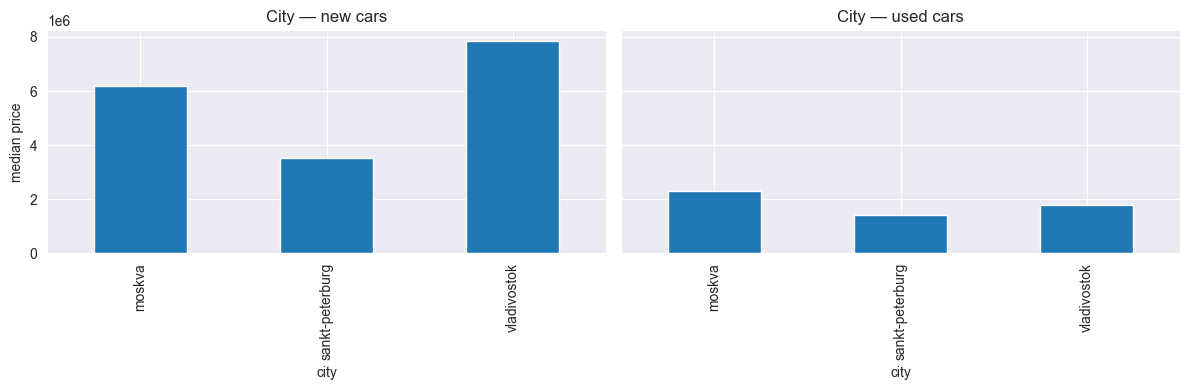

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

df_new.groupby("city")["price"].median().plot(
    kind="bar", ax=axes[0], title="City — new cars"
)

df_used.groupby("city")["price"].median().plot(
    kind="bar", ax=axes[1], title="City — used cars"
)

for ax in axes:
    ax.set_ylabel("median price")

plt.tight_layout()
plt.show()

## Часть 3. Обучение модели

In [243]:
cat_features = [
    "city",
    "brand",
    "model",
    "color",

    "body_type",
    "drive_type",
    "transmission",
    "engine_type",
    "is_left_hand_drive",
]

In [244]:
num_features = [
    "tax_per_year",
    "year",
    "km-age",
    "engine_volume",
    "power_hp",
]

In [269]:
def plot_feature_importance(model, X, title):
    fi = pd.DataFrame({
        "feature": X.columns,
        "importance": model.get_feature_importance()
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=fi.head(15),
        x="importance",
        y="feature"
    )
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("")
    plt.show()

In [270]:
def train_catboost(df_part, cat_features, label=""):
    df_part[cat_features] = df_part[cat_features].fillna("unknown")

    X = df_part.drop(columns=["price", "log_price", "url", "is_new"])
    y = df_part["log_price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=500,
        depth=8,
        learning_rate=0.05,
        loss_function="RMSE",
        random_seed=42,
        verbose=100
    )

    model.fit(
        X_train,
        y_train,
        cat_features=cat_features
    )

    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    baseline_pred = np.median(y_train)
    baseline_pred = np.exp(baseline_pred)

    mae = mean_absolute_error(y_true, y_pred)
    baseline_mae = mean_absolute_error(y_true, np.full_like(y_true, baseline_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n{label} results:")
    print(f"MAE: {mae:.0f} rub")
    print(f"Baseline MAE: {baseline_mae:.0f} rub")
    print(f"MAPE: {mape:.2f} %")
    
    df_eval = X_test.copy()
    df_eval["real_price"] = np.expm1(y_test)
    df_eval["pred_price"] = np.expm1(y_pred_log)
    
    df_eval["abs_error"] = abs(df_eval["pred_price"] - df_eval["real_price"])
    df_eval["ape"] = df_eval["abs_error"] / df_eval["real_price"] * 100

    price_bins = pd.cut(
        df_eval["real_price"],
        bins=[0, 500_000, 1_000_000, 2_000_000, 3_000_000, 5_000_000, 10_000_000],
        right=False
    )

    df_eval["price_bin"] = price_bins

    heatmap_data = (
        df_eval
        .groupby("price_bin")["ape"]
        .mean()
        .to_frame(name="MAPE")
    )

    plt.figure(figsize=(8, 4))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="Reds"
    )
    plt.title("MAPE by price segment (%)")
    plt.xlabel("Metric")
    plt.ylabel("Real price segment")
    plt.show()

    plot_feature_importance(model, X_train, f"Feature importance {label}")

    return model, X_test, y_test

0:	learn: 1.0524948	total: 17.6ms	remaining: 8.81s
100:	learn: 0.3064149	total: 919ms	remaining: 3.63s
200:	learn: 0.2618444	total: 1.76s	remaining: 2.61s
300:	learn: 0.2361410	total: 2.53s	remaining: 1.67s
400:	learn: 0.2156421	total: 3.32s	remaining: 819ms
499:	learn: 0.2020413	total: 4.08s	remaining: 0us

ALL CARS results:
MAE: 1168440 rub
Baseline MAE: 3689658 rub
MAPE: 18.28 %


/var/folders/d4/mx_q43ld49s2_b53dscjwct00000gn/T/ipykernel_6380/1635629656.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin")["ape"]


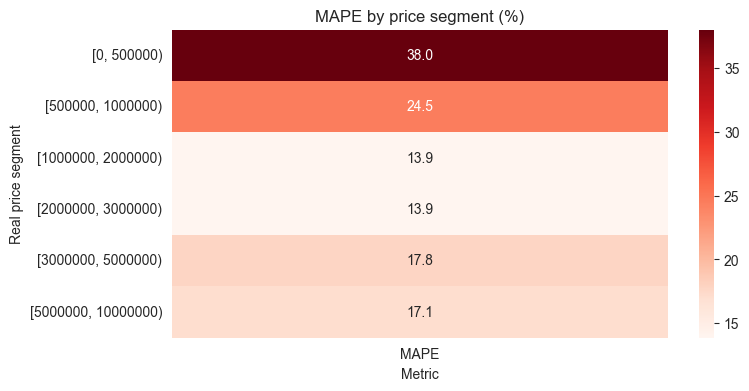

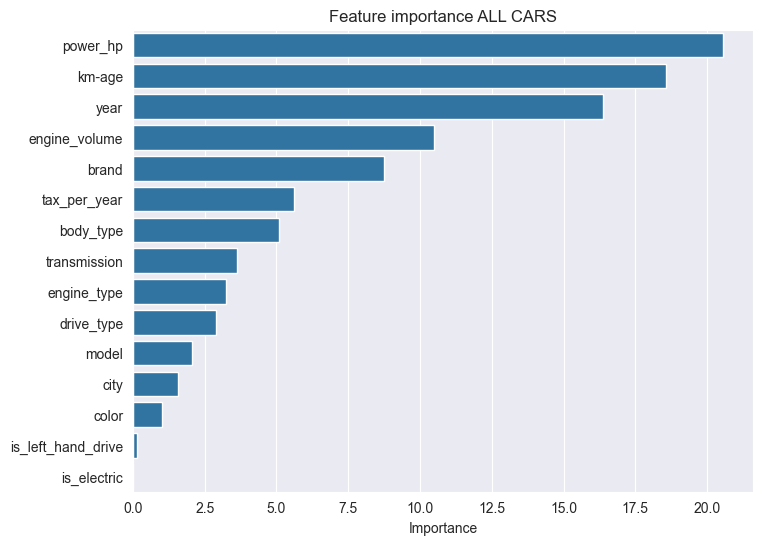

In [271]:
model, X_test, y_test = train_catboost(
    df,
    cat_features=cat_features,
    label="ALL CARS"
)

0:	learn: 0.8858555	total: 4.15ms	remaining: 2.07s
100:	learn: 0.1812059	total: 404ms	remaining: 1.59s
200:	learn: 0.1283870	total: 839ms	remaining: 1.25s
300:	learn: 0.1023611	total: 1.25s	remaining: 828ms
400:	learn: 0.0863155	total: 1.78s	remaining: 439ms
499:	learn: 0.0767528	total: 2.37s	remaining: 0us

NEW CARS results:
MAE: 1256625 rub
Baseline MAE: 5929702 rub
MAPE: 12.58 %


/var/folders/d4/mx_q43ld49s2_b53dscjwct00000gn/T/ipykernel_6380/1635629656.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin")["ape"]


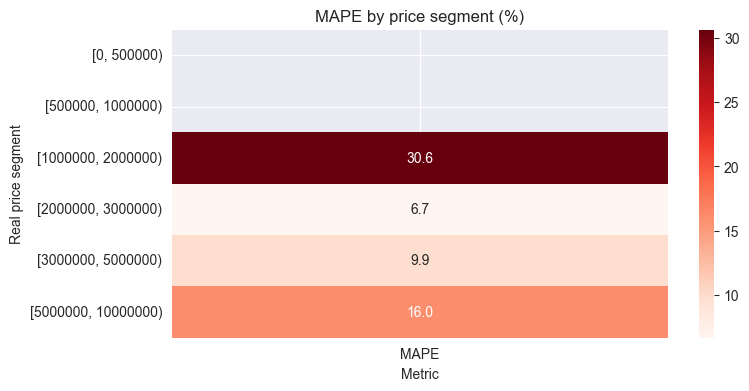

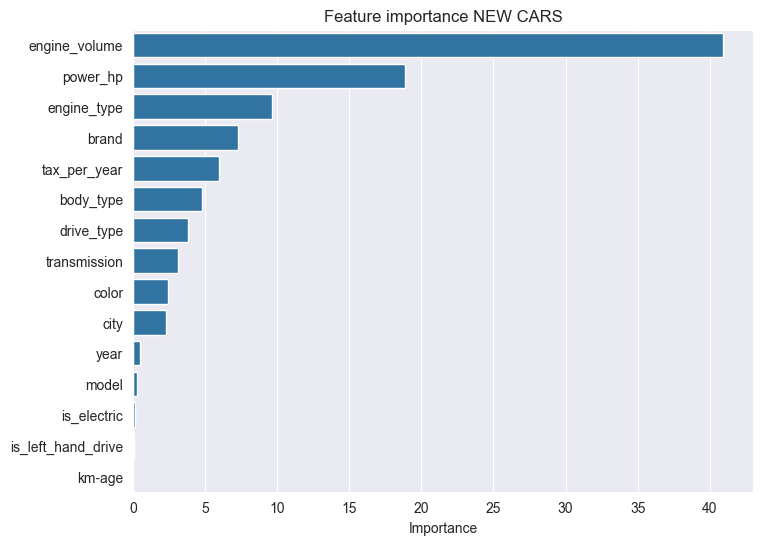

In [272]:
model_new, X_test_new, y_test_new = train_catboost(
    df_new,
    cat_features=cat_features,
    label="NEW CARS"
)

0:	learn: 1.0208845	total: 10ms	remaining: 4.99s
100:	learn: 0.3119988	total: 796ms	remaining: 3.14s
200:	learn: 0.2707726	total: 1.61s	remaining: 2.4s
300:	learn: 0.2414136	total: 2.42s	remaining: 1.6s
400:	learn: 0.2218280	total: 3.25s	remaining: 801ms
499:	learn: 0.2048535	total: 4s	remaining: 0us

USED CARS results:
MAE: 1070834 rub
Baseline MAE: 3036763 rub
MAPE: 18.27 %


/var/folders/d4/mx_q43ld49s2_b53dscjwct00000gn/T/ipykernel_6380/1635629656.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin")["ape"]


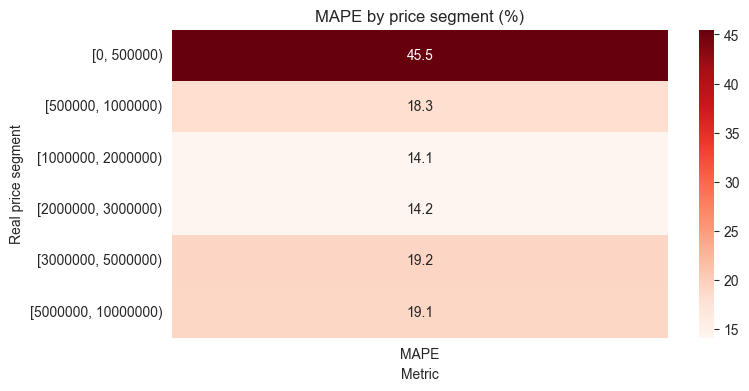

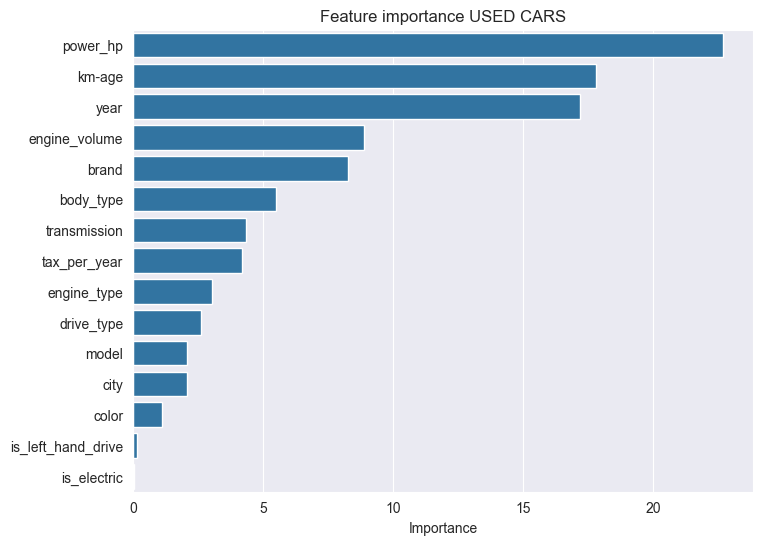

In [273]:
model_used, X_test_used, y_test_used = train_catboost(
    df_used,
    cat_features=cat_features,
    label="USED CARS"
)

### Влияние характеристик автомобиля на его цену на общей модели

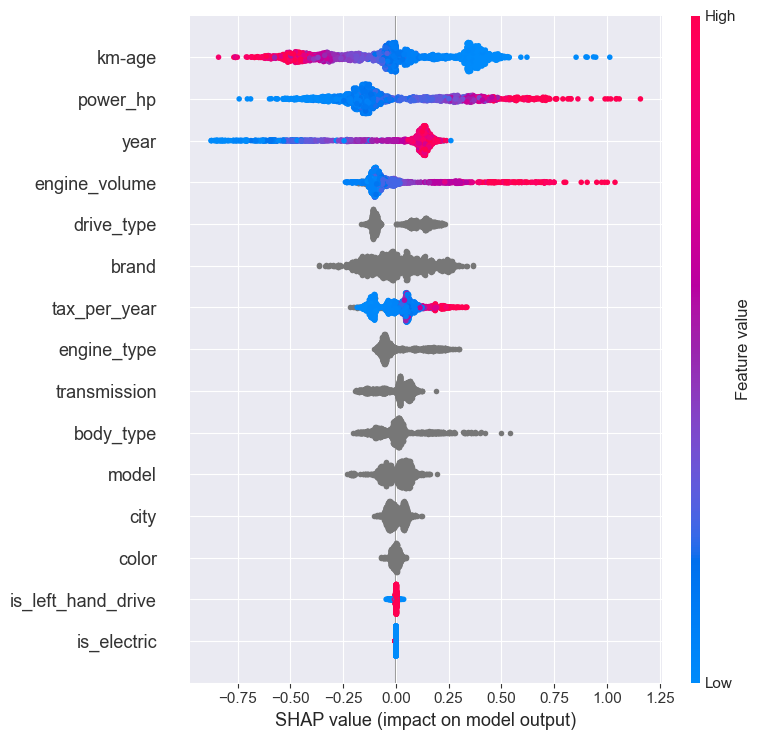

In [249]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### Влияние характеристик автомобиля на его цену на модели новых авто

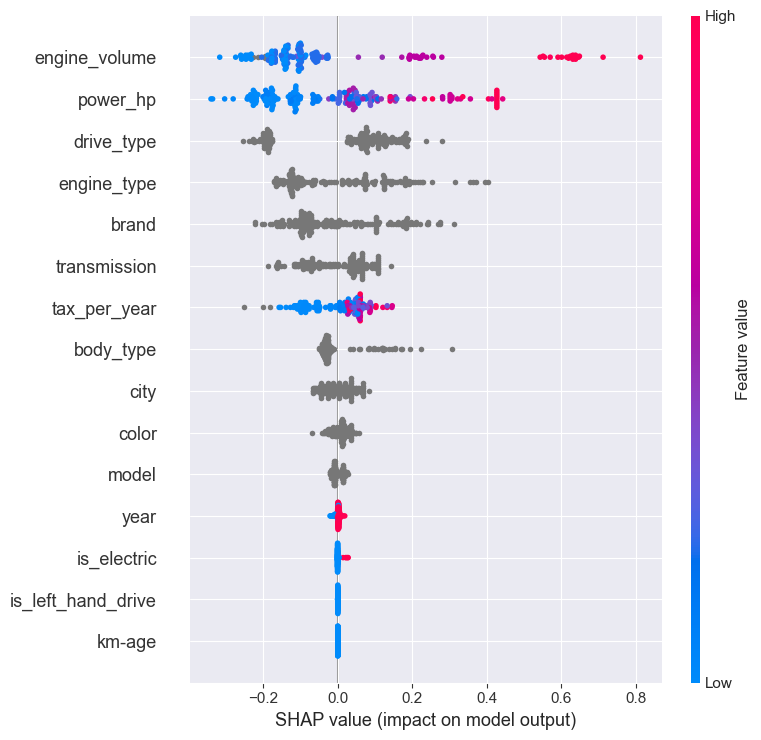

In [250]:
explainer = shap.TreeExplainer(model_new)
shap_values = explainer.shap_values(X_test_new)

shap.summary_plot(shap_values, X_test_new)

### Влияние характеристик автомобиля на его цену на модели подержанных авто

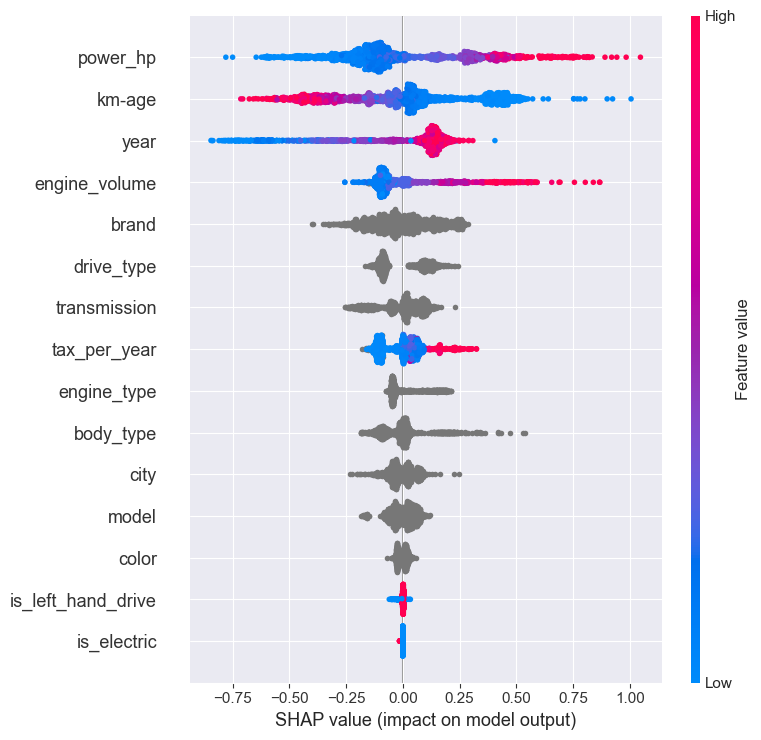

In [251]:
explainer = shap.TreeExplainer(model_used)
shap_values = explainer.shap_values(X_test_used)

shap.summary_plot(shap_values, X_test_used)

In [256]:
i = 10
x_single = X_test.iloc[[i]]
print(x_single)

pred_price = np.exp(model.predict(x_single))[0]
real_price = np.exp(y_test.iloc[i])

print(f"{pred_price:.2f}, {real_price:.2f}")

                 city  tax_per_year  year  km-age          brand  \
5556  sankt-peterburg       75450.0  2021   50543  Mercedes-Benz   

                model   color body_type drive_type transmission engine_type  \
5556  Maybach S-Класс  чёрный     седан     полный    automatic      petrol   

      engine_volume  power_hp  is_left_hand_drive  is_electric  
5556            4.0       503                True        False  
12958227.69, 18790000.00


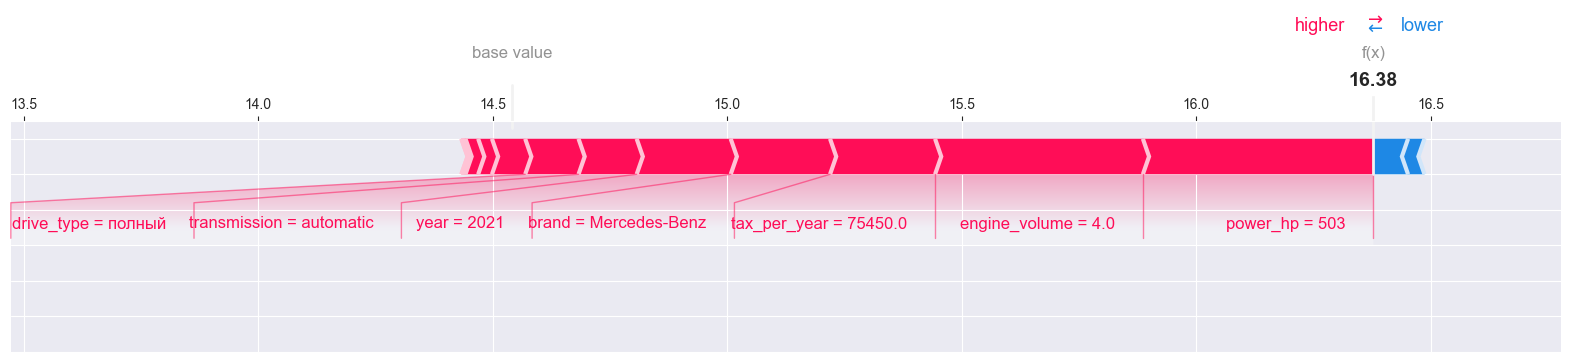

In [257]:
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(x_single),
    x_single,
    matplotlib=True
)

In [258]:
i = 10
x_single = X_test_new.iloc[[i]]
print(x_single)

pred_price = np.exp(model_new.predict(x_single))[0]
real_price = np.exp(y_test_new.iloc[i])

print(f"{pred_price:.2f}, {real_price:.2f}")

                 city  tax_per_year  year  km-age  brand model  color  \
3768  sankt-peterburg        3955.0  2025       0  TENET    T4  серый   

     body_type drive_type transmission engine_type  engine_volume  power_hp  \
3768       suv   передний       manual      petrol            1.5       113   

      is_left_hand_drive  is_electric  
3768                True        False  
2055777.33, 1999000.00


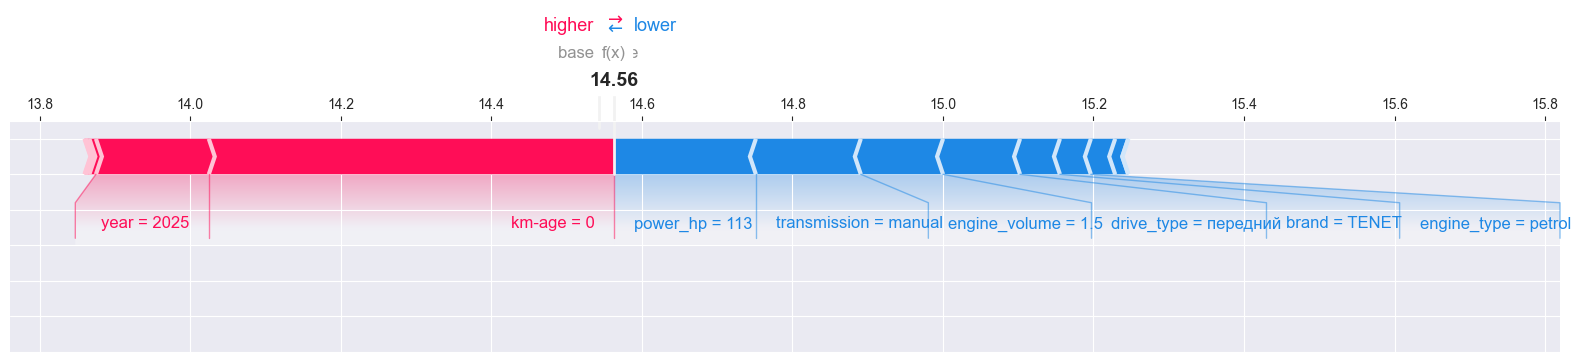

In [259]:
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(x_single),
    x_single,
    matplotlib=True
)

In [260]:
i = 10
x_single = X_test_used.iloc[[i]]
print(x_single)

pred_price = np.exp(model_used.predict(x_single))[0]
real_price = np.exp(y_test_used.iloc[i])

print(f"{pred_price:.2f}, {real_price:.2f}")

        city  tax_per_year  year  km-age brand    model    color  body_type  \
2421  moskva       47250.0  2024   17311  Ford  Mustang  красный  кабриолет   

     drive_type transmission engine_type  engine_volume  power_hp  \
2421     задний    automatic      petrol            2.3       315   

      is_left_hand_drive  is_electric  
2421                True        False  
6699333.13, 7949999.00


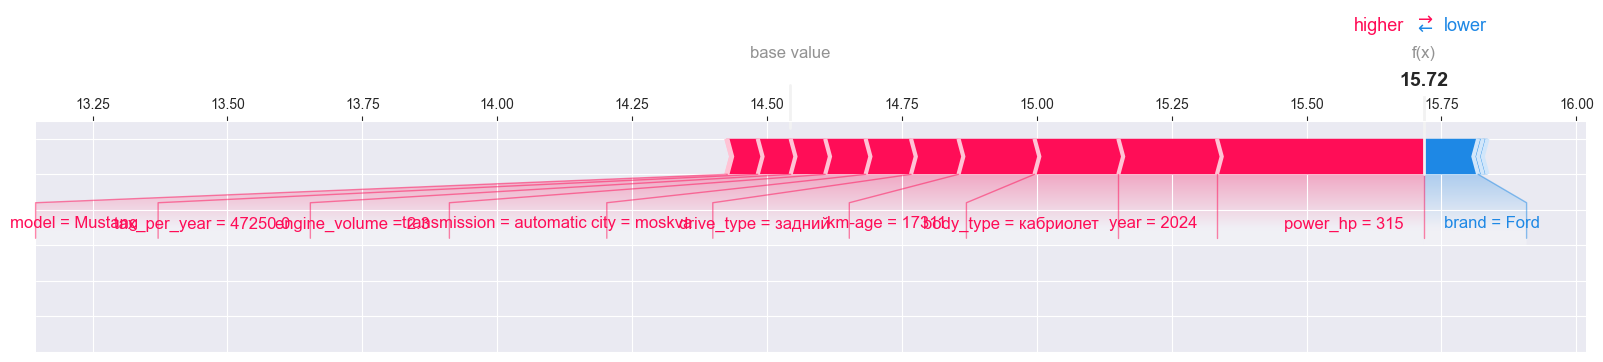

In [261]:
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(x_single),
    x_single,
    matplotlib=True
)